# Text classification with BERT in PyTorch

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

import os

os.chdir("/content/drive/My Drive/DM-HW4")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


2018 was an exciting year for Natural Language Processing. One of the most promising evolutions was the breakthrough of transfer learning. Models like Elmo Embeddings, ULMFit and BERT allow us to pre-train a neural network on a large collection of unlabelled texts. Thanks to an auxiliary task such as language modelling, these models are able to learn a lot about the syntax, semantics and morphology of a language. This knowledge can be put to good use: because they already know so much about language use, these models need much less labelled data to reach state-of-the-art performance on other tasks, such as text classification, sequence labelling or question answering. 

One of the most popular models is [BERT](https://arxiv.org/abs/1810.04805), developed by researchers at Google. BERT stands for Bidirectional Encoder Representations from Transformers. It uses the Transformer architecture to pretrain bidirectional "language models". By adding just one task-specific output layer, it is possible to use such a pre-trained BERT model on a variety of NLP tasks. In this notebook, we're going to investigate its performance on a sentiment analysis task, where the task is to predict whether a review is positive or negative. Unfortunately, we can't share the data, but you can easily plug in your own.

## Data



1.   Split dataset into train,val and test
2.   Remove rows containing Nan
3.  Delete Categories whose size are extremely small



size of original dataset 362237
size of dataset without nan 266557


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Train size: 170222
Dev size: 21191
Test size: 21285
<class 'pandas.core.series.Series'>
Rock       87341
Pop        32384
Hip-Hop    19883
Metal      19021
Country    11593
Name: genre, dtype: int64


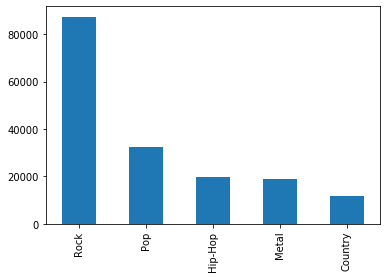

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_20newsgroups
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from nltk import pos_tag
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans

import sys
from time import time

import numpy as np
import pandas as pd

data = pd.read_csv("lyrics.csv")

print('size of original dataset', len(data))
data.dropna(subset=['lyrics'],inplace=True)
print('size of dataset without nan', len(data))

# shuffle the dataset
data = data.sample(frac=1).reset_index(drop=True)

# train= 80% | valid = 10% | test = 10%
train_size = int(len(data)*0.8)
val_size = int(len(data)*0.1)
test_size = int(len(data)*0.1)
train = data.loc[:train_size,:]
val = data.loc[train_size:train_size + val_size , :]
test = data.loc[train_size + val_size:, :]
                
delete_attributes = ['Not Available','Jazz','Electronic','Other','R&B','Indie','Folk']
dataset = [train,val,test]
for attr in delete_attributes:
    for sets in dataset:
        data_index = sets[sets['genre'] == attr].index
        sets.drop(data_index, inplace=True)

enhence_attributes=[]
#enhence_attributes = [('Hip-Hop',3),('Metal',3),('Country',5),('Pop',1)]
for attr,frac in enhence_attributes:
    tmp_data = train[train['genre'] == attr]
    for i in range(frac):
        train = train.append(tmp_data)

print("Train size:", len(train))
print("Dev size:", len(val))
print("Test size:", len(test))

# explore the number of each genre
class_count = train['genre'].value_counts()
print(type(class_count))
print(class_count)
class_count.plot(kind='bar')

[链接文字](https://)

1.   Feature Engineering
2.   Sample dataset



{'Hip-Hop': 0, 'Pop': 1, 'Metal': 2, 'Country': 3, 'Rock': 4}
995
1620
952
580
4368
126
207
119
71
540
124
198
119
70
556
<class 'pandas.core.series.Series'>
Rock       4368
Pop        1620
Hip-Hop     995
Metal       952
Country     580
Name: genre, dtype: int64
size of train_sample 8515
size of val_sample 1063
size of test_sample 1067


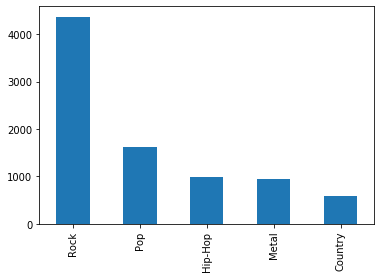

In [3]:
# reset the index, otherwise, we will encounter errors 
#test.reset_index(drop=True, inplace=True)
#val.reset_index(drop=True, inplace=True)
target_names = list(set(train['genre']))
label2idx = {label: idx for idx, label in enumerate(target_names)}
print(label2idx)

# shuffle
train = train.sample(frac=1).reset_index(drop=True)
val = val.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)
def feature_engineer(data,feature_list):
    for index, row in data.iterrows():
        for f in feature_list:
            data.loc[index,'lyrics'] = row[f] + ' ' + row['lyrics']



ratio = 0.05

enhence_attributes = [('Hip-Hop',3),('Metal',3),('Country',5),('Pop',1)]
def generate_sample_data(original_data,ratio):

    sample_data = pd.DataFrame(columns=original_data.columns) 

    for label in target_names:
        tmp_data = original_data[original_data['genre'] == label].reset_index(drop=True)
        sample_size = int(len(tmp_data)*ratio)
        tmp_data = tmp_data.loc[:sample_size,:]
        print(len(tmp_data))
        sample_data = sample_data.append(tmp_data)
    return sample_data

train_sample = generate_sample_data(train, ratio)                      
val_sample = generate_sample_data(val, ratio)         
test_sample = generate_sample_data(test, ratio)         

# shuffle
train_sample = train_sample.sample(frac=1).reset_index(drop=True)
val_sample = val_sample.sample(frac=1).reset_index(drop=True)
test_sample = test_sample.sample(frac=1).reset_index(drop=True)

extra_features = ['song','artist']
feature_engineer(train_sample,extra_features)
feature_engineer(val_sample,extra_features)
feature_engineer(test_sample,extra_features)

# explore the number of each genre
class_count = train_sample['genre'].value_counts()
print(type(class_count))
print(class_count)
class_count.plot(kind='bar')

print('size of train_sample', len(train_sample))
print('size of val_sample', len(val_sample))
print('size of test_sample', len(test_sample))

train_texts = train_sample['lyrics']
train_labels = train_sample['genre']

dev_texts = val_sample['lyrics']
dev_labels = val_sample['genre']

test_texts = test_sample['lyrics']
test_labels = test_sample['genre']

## Baseline

Let's train a baseline model for our task. In this way we have something to compare BERT's performance to. As our baseline, we choose a simple Logistic Regression classifier from Scikit-learn. We use grid search to find the optimal settings for its hyperparameter _C_. At the end of this process, we find that our best baseline classifier obtains an accuracy of 62.67%.

In [0]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression(multi_class="ovr", solver="lbfgs"))
])

#parameters = {'lr__C': [0.1, 0.5, 1, 2,]}

#best_classifier = GridSearchCV(pipeline, parameters, cv=5, verbose=1)
#best_classifier.fit(train_texts, train_labels)
#best_predictions = best_classifier.predict(test_texts)

#baseline_accuracy = np.mean(best_predictions == test_labels)
#print("Baseline accuracy:", baseline_accuracy)

## BERT

Now we move to BERT. The team at [HuggingFace](https://github.com/huggingface) has developed a great Python library, [transformers](https://github.com/huggingface/transformers), with implementations of an impressive number of transfer-learning models in PyTorch and Tensorflow. It makes finetuning these models pretty easy. Let's first install this library. 

In [5]:
!git clone https://github.com/huggingface/transformers
!pip install transformers/.

fatal: destination path 'transformers' already exists and is not an empty directory.
Processing ./transformers
     |████████████████████████████████| 3.1MB 3.4MB/s 
     |████████████████████████████████| 1.0MB 29.9MB/s 
     |████████████████████████████████| 870kB 43.6MB/s 
  Created wheel for transformers: filename=transformers-2.3.0-cp36-none-any.whl size=466922 sha256=85845164deb9b1cb381636cca5c2b7df4496620498109246145bb2277b93a542
  Stored in directory: /tmp/pip-ephem-wheel-cache-dij67o0p/wheels/e1/a8/8d/0381faabe23d3fbd6d9b19a76e8ff175a740b0a3c649b07a7c
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884629 sha256=844a990de4f0dff0500515d7c6bc7c3a4b6f3962cc72906de334b9dca7ffb9c9
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built transformers sacremoses


You really need a GPU to finetune BERT. Still, to make sure this code runs on any machine we'll let PyTorch determine whether a GPU is available.

In [0]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Initializing a model

Google has made available a range of BERT models for us to experiment with. For English, there is a choice between three models: `bert-large-uncased` is the largest model that will likely give the best results. Its smaller siblings are `bert-base-uncased` and `bert-base-cased`, which are more practical to work with. For Chinese there is `bert-base-chinese`, and for the other languages we have `bert-base-multilingual-uncased` and `bert-base-multilingual-cased`. 

Uncased means that the training text has been lowercased and accents have been stripped. This is usually better, unless you know that case information is important for your task, such as with Named Entity Recognition. 

In our example, we're going to investigate sentiment analysis on English. We'll therefore use the English BERT-base model.

In [0]:
BERT_MODEL = "bert-base-uncased"

Each model comes with its own tokenizer. This tokenizer splits texts into [word pieces](https://github.com/google/sentencepiece). In addition, we'll tell the tokenizer it should lowercase the text, as we're going to work with the uncased model. 

In [8]:
from transformers.tokenization_bert import BertTokenizer

tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)

A full BERT model consists of a common, pretrained core, and an extension on top that depends on the particular NLP task. After all, the output of a sequence classification model, where we have just one prediction for every sequence, looks very different from the output of a sequence labelling or question answering model. As we're looking at sentiment classification, we're going to use the pretrained BERT model with a final layer for sequence classification on top.

In [9]:
from transformers.modeling_bert import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels = len(label2idx))
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### Preparing the data

Next we need to prepare our data for BERT. We'll present every document as a BertInputItem object, which contains all the information BERT needs: 

- a list of input ids. Take a look at the logging output to see what this means. Every text has been split up into subword units, which are shared between all the languages in the multilingual model. When a word appears frequently enough in a combined corpus of all languages, it is kept intact. If it is less frequent, it is split up into subword units that do occur frequently enough across all languages. This allows our model to process every text as a sequence of strings from a finite vocabulary of limited size. Note also the first `[CLS]` token. This token is added at the beginning of every document. The vector at the output of this token will be used by the BERT model for its sequence classification tasks: it serves as the input of the final, task-specific part of the neural network.
- the input mask: the input mask tells the model which parts of the input it should look at and which parts it should ignore. In our example, we have made sure that every text has a length of 100 tokens. This means that some texts will be cut off after 100 tokens, while others will have to be padded with extra tokens. In this latter case, these padding tokens will receive a mask value of 0, which means BERT should not take them into account for its classification task. 
- the segment_ids: some NLP task take several sequences as input. This is the case for question answering, natural language inference, etc. In this case, the segment ids tell BERT which sequence every token belongs to. In a text classification task like ours, however, there's only one segment, so all the input tokens receive segment id 0.
- the label id: the id of the label for this document.

In [0]:
import logging
import numpy as np

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

MAX_SEQ_LENGTH=100

class BertInputItem(object):
    """An item with all the necessary attributes for finetuning BERT."""

    def __init__(self, text, input_ids, input_mask, segment_ids, label_id):
        self.text = text
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id
        

def convert_examples_to_inputs(example_texts, example_labels, label2idx, max_seq_length, tokenizer, verbose=0):
    """Loads a data file into a list of `InputBatch`s."""
    
    input_items = []
    examples = zip(example_texts, example_labels)
    for (ex_index, (text, label)) in enumerate(examples):

        # Create a list of token ids
        input_ids = tokenizer.encode(f"[CLS] {text} [SEP]",max_length=512)
        if len(input_ids) > max_seq_length:
            input_ids = input_ids[:max_seq_length]

        # All our tokens are in the first input segment (id 0).
        segment_ids = [0] * len(input_ids)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        label_id = label2idx[label]

        input_items.append(
            BertInputItem(text=text,
                          input_ids=input_ids,
                          input_mask=input_mask,
                          segment_ids=segment_ids,
                          label_id=label_id))

        
    return input_items

train_features = convert_examples_to_inputs(train_texts, train_labels, label2idx, MAX_SEQ_LENGTH, tokenizer, verbose=0)
dev_features = convert_examples_to_inputs(dev_texts, dev_labels, label2idx, MAX_SEQ_LENGTH, tokenizer)
test_features = convert_examples_to_inputs(test_texts, test_labels, label2idx, MAX_SEQ_LENGTH, tokenizer)

In [11]:
train_features[1]

Finally, we're going to initialize a data loader for our training, development and testing data. This data loader puts all our data in tensors and will allow us to iterate over them during training.

In [0]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

def get_data_loader(features, max_seq_length, batch_size, shuffle=True): 

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

    dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size)
    return dataloader

BATCH_SIZE = 50

train_dataloader = get_data_loader(train_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=True)
dev_dataloader = get_data_loader(dev_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)
test_dataloader = get_data_loader(test_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)

### Evaluation method

Now it's time to write our evaluation method. This method takes as input a model and a data loader with the data we would like to evaluate on. For each batch, it computes the output of the model and the loss. We use this output to compute the obtained precision, recall and F-score. During training, we will print the simple numbers. When we evaluate on the test set, we will output a full classification report.

In [0]:
def evaluate(model, dataloader):
    model.eval()
    
    eval_loss = 0
    nb_eval_steps = 0
    predicted_labels, correct_labels = [], []

    for step, batch in enumerate(tqdm(dataloader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
            tmp_eval_loss, logits = model(input_ids, attention_mask=input_mask,
                                          token_type_ids=segment_ids, labels=label_ids)

        outputs = np.argmax(logits.to('cpu'), axis=1)
        label_ids = label_ids.to('cpu').numpy()
        
        predicted_labels += list(outputs)
        correct_labels += list(label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    
    correct_labels = np.array(correct_labels)
    predicted_labels = np.array(predicted_labels)
        
    return eval_loss, correct_labels, predicted_labels

### Training

Now it's time to start training. We're going to use the AdamW optimizer with a base learning rate of 5e-5, and train for a maximum of 100 epochs. Here are some additional things to note: 

- Gradient Accumulation allows us to keep our batches small enough to fit into the memory of our GPU, while getting the advantages of using larger batch sizes. In practice, it means we sum the gradients of several batches, before we perform a step of gradient descent. 
- We use the WarmupLinearScheduler to vary our learning rate during the training process. First, we're going to start with a small learning rate, which increases linearly during the warmup stage. Afterwards it slowly decreases again.

In [0]:
from transformers.optimization import AdamW,get_linear_schedule_with_warmup

GRADIENT_ACCUMULATION_STEPS = 1
NUM_TRAIN_EPOCHS = 20
LEARNING_RATE = 1e-5
WARMUP_PROPORTION = 0.1
MAX_GRAD_NORM = 5

num_train_steps = int(len(train_dataloader.dataset) / BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(WARMUP_PROPORTION * num_train_steps)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE, correct_bias=False)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)

We're finally ready to train our model. At each epoch, we're going to train it on our training data and evaluate it on the development data. We keep a history of the loss, and stop training when the loss on the development set doesn't improve for a certain number of steps (we call this number our `patience`). Whenever the development loss of our model improves, we save it. 

In [15]:
!mkdir ./tmp/debug_total_balanced

mkdir: cannot create directory ‘./tmp/debug_total_balanced’: File exists


In [16]:
import torch
import os
from tqdm import trange
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import classification_report, precision_recall_fscore_support

OUTPUT_DIR = "./tmp/debug_total_balanced"

MODEL_FILE_NAME = "pytorch_model.bin"
PATIENCE = 5

loss_history = []
no_improvement = 0
for _ in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        outputs = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids)
        loss = outputs[0]

        if GRADIENT_ACCUMULATION_STEPS > 1:
            loss = loss / GRADIENT_ACCUMULATION_STEPS

        loss.backward()
        tr_loss += loss.item()

        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)  
            
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            
    dev_loss, _, _ = evaluate(model, dev_dataloader)
    
    print("Loss history:", loss_history)
    print("Dev loss:", dev_loss)
    
    if len(loss_history) == 0 or dev_loss < min(loss_history):
        no_improvement = 0
        model_to_save = model.module if hasattr(model, 'module') else model
        output_model_file = os.path.join(OUTPUT_DIR, MODEL_FILE_NAME)
        torch.save(model_to_save.state_dict(), output_model_file)
    else:
        no_improvement += 1
    
    if no_improvement >= PATIENCE: 
        print("No improvement on development set. Finish training.")
        break
        
    
    loss_history.append(dev_loss)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]


Loss history: []
Dev loss: 0.9685221964662726


Epoch:   5%|▌         | 1/20 [02:55<55:29, 175.25s/it]


Loss history: [0.9685221964662726]
Dev loss: 0.6920936879786578


Epoch:  10%|█         | 2/20 [05:52<52:44, 175.80s/it]


Loss history: [0.9685221964662726, 0.6920936879786578]
Dev loss: 0.5976972065188668


Epoch:  15%|█▌        | 3/20 [08:49<49:53, 176.11s/it]


Loss history: [0.9685221964662726, 0.6920936879786578, 0.5976972065188668]
Dev loss: 0.5109257291663777


Epoch:  20%|██        | 4/20 [11:45<47:00, 176.27s/it]


Loss history: [0.9685221964662726, 0.6920936879786578, 0.5976972065188668, 0.5109257291663777]
Dev loss: 0.486825556917624


Epoch:  25%|██▌       | 5/20 [14:42<44:05, 176.36s/it]


Loss history: [0.9685221964662726, 0.6920936879786578, 0.5976972065188668, 0.5109257291663777, 0.486825556917624]
Dev loss: 0.46917653422464023


Epoch:  30%|███       | 6/20 [17:39<41:10, 176.46s/it]

Epoch:  35%|███▌      | 7/20 [20:34<38:09, 176.11s/it]


Loss history: [0.9685221964662726, 0.6920936879786578, 0.5976972065188668, 0.5109257291663777, 0.486825556917624, 0.46917653422464023]
Dev loss: 0.5025733424858614


01/20/2020 21:13:09 - INFO - numexpr.utils -   NumExpr defaulting to 2 threads.


KeyboardInterrupt: ignored

### Evaluation

Let's now evaluate the model on some documents it has never seen. We'll load our best model and have it predict the labels for all documents in our data. We'll compute its precision, recall and F-score for the training, development and test set and print a full classification report for the test set.

In [17]:
model_state_dict = torch.load(os.path.join(OUTPUT_DIR, MODEL_FILE_NAME), map_location=lambda storage, loc: storage)
model = BertForSequenceClassification.from_pretrained(BERT_MODEL, state_dict=model_state_dict, num_labels = len(target_names))
model.to(device)

model.eval()

_, train_correct, train_predicted = evaluate(model, train_dataloader)
_, dev_correct, dev_predicted = evaluate(model, dev_dataloader)
_, test_correct, test_predicted = evaluate(model, test_dataloader)

print("Training performance:", precision_recall_fscore_support(train_correct, train_predicted, average="micro"))
print("Development performance:", precision_recall_fscore_support(dev_correct, dev_predicted, average="micro"))
print("Test performance:", precision_recall_fscore_support(test_correct, test_predicted, average="micro"))

bert_accuracy = np.mean(test_predicted == test_correct)

print(classification_report(test_correct, test_predicted, target_names=target_names))

01/20/2020 21:13:14 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.bf3b9ea126d8c0001ee8a1e8b92229871d06d36d8808208cc2449280da87785c
01/20/2020 21:13:14 - INFO - transformers.configuration_utils -   Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "do_sample": false,
  "eos_token_ids": 0,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads"


Training performance: (0.9877862595419847, 0.9877862595419847, 0.9877862595419848, None)
Development performance: (0.8748824082784572, 0.8748824082784572, 0.8748824082784572, None)
Test performance: (0.8687910028116214, 0.8687910028116214, 0.8687910028116214, None)
              precision    recall  f1-score   support

     Hip-Hop       0.89      0.81      0.85       124
         Pop       0.81      0.85      0.83       198
       Metal       0.74      0.88      0.81       119
     Country       0.84      0.91      0.88        70
        Rock       0.92      0.88      0.90       556

    accuracy                           0.87      1067
   macro avg       0.84      0.87      0.85      1067
weighted avg       0.87      0.87      0.87      1067



We see that BERT obtains an accuracy of around 70% on the test data. This is around 8% more than our initial baseline classifier. This confirms that BERT's transfer learning helps us achieve significantly higher accuracies for small datasets.

In [0]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({"accuracy": {"baseline": baseline_accuracy, "BERT": bert_accuracy}})
plt.rcParams['figure.figsize'] = (7,4)
df.plot(kind="bar")